<a href="https://colab.research.google.com/github/thihanaung-thnn/TBXray_classification/blob/main/03_covid_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip -qq /content/drive/MyDrive/archive.zip
!unzip -qq /content/drive/MyDrive/COVID-19_Radiography_Database.zip

# Import Libraries and Paths

In [4]:
import os
import shutil
from pathlib import Path
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from datetime import datetime
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array , array_to_img
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl

In [5]:
# tb_path = Path('/content/TB_Chest_Radiography_Database/Tuberculosis')
normal_path = Path('/content/COVID-19_Radiography_Dataset/Normal')
# normal_path2 = Path('/content/TB_Chest_Radiography_Database/Normal')
pneumonia_path = Path('/content/COVID-19_Radiography_Dataset/Viral Pneumonia')
covid_path = Path('/content/COVID-19_Radiography_Dataset/COVID')
opacity_path = Path('/content/COVID-19_Radiography_Dataset/Lung_Opacity')

normal_mask_path = Path('/content/drive/MyDrive/Colab Notebooks/Augmented/normal')
pneumonia_mask_path = Path('/content/drive/MyDrive/Colab Notebooks/Augmented/viral_pneumonia')
covid_mask_path = Path('/content/drive/MyDrive/Colab Notebooks/Augmented/covid')
opacity_mask_path = Path('/content/drive/MyDrive/Colab Notebooks/Augmented/lung_opacity')

# print(f'Number of TB X-rays :{len(list((tb_path.iterdir())))}')
print(f'Number of COVID X-rays : {len(list(covid_path.iterdir()))}')
print(f'Number of Pneumonia X-rays : {len(list(pneumonia_path.iterdir()))}')
print(f'Number of Lung opacity X-rays : {len(list(opacity_path.iterdir()))}')
print(f'Number of Normal X-rays : {len(list(normal_path.iterdir()))}')
# print(f'Number of Normal X-rays2: {len(list(normal_path2.iterdir()))}')

Number of COVID X-rays : 3616
Number of Pneumonia X-rays : 1345
Number of Lung opacity X-rays : 6012
Number of Normal X-rays : 10192


In [6]:
# covid_list = list(covid_path.iterdir())[:1345]
# pneumonia_list = list(pneumonia_path.iterdir())
# opacity_list = list(opacity_path.iterdir())[:1345]
# normal_list = list(normal_path.iterdir())[:1345]
covid_mask_list = list(covid_mask_path.iterdir())
pneumonia_mask_list = list(pneumonia_mask_path.iterdir())
opacity_mask_list = list(opacity_mask_path.iterdir())
normal_mask_list = list(normal_mask_path.iterdir())

In [7]:
# augmented_path = Path('/content/drive/MyDrive/Colab Notebooks/Augmented')
unet_model = load_model('/content/drive/MyDrive/unet_lung_seg.hdf5', compile=False)

In [8]:
# def test_load_image(test_file, target_size=(512,512)):
#   img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
#   img = img / 255 
#   img = cv2.resize(img, target_size)
#   img = np.reshape(img, img.shape + (1,))
#   return img 

# def make_mask_image(img_list, name):
#   for ind, path in enumerate(img_list):
#     img_arr = test_load_image(str(path))
#     img_arr = img_arr.reshape((1, 512, 512, 1))
#     result = unet_model.predict(img_arr) 
#     mask_img = (np.where(result > 0.5, 1, 0)*img_arr).reshape(512, 512, 1)
#     filename = str(ind) + '.png'
#     tf.keras.utils.save_img(augmented_path / name / filename, mask_img)


In [ ]:
# make_mask_image(covid_list, 'covid')
# make_mask_image(pneumonia_list, 'viral_pneumonia')
# make_mask_image(opacity_list, 'lung_opacity')
# make_mask_image(normal_list, 'normal')

# Create Path DataFrame

In [6]:
all_labels = []
all_paths = []

path_list = [pneumonia_path, covid_path, opacity_path, normal_path]
label_list = ['Viral Pneumonia', 'COVID', 'Pneumonia', 'Normal']

for paths, label in zip(path_list, label_list):
    for path in paths.iterdir():
        all_paths.append(str(path))
        all_labels.append(label)

df = pd.DataFrame({'paths':all_paths, 'label':all_labels})
# df = df.groupby('label').sample(3600)
df['label'].value_counts()

Normal             10192
Pneumonia           6012
COVID               3616
Viral Pneumonia     1345
Name: label, dtype: int64

In [7]:
x_train, x_tv, y_train, y_tv = train_test_split(df['paths'], df['label'], stratify=df['label'],
                                                random_state=123, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_tv, y_tv, stratify=y_tv,
                                                random_state=123, test_size=0.5)

train_df = pd.DataFrame({'path':x_train, 'target':y_train}).reset_index(drop=True)
val_df = pd.DataFrame({'path':x_val, 'target':y_val}).reset_index(drop=True)
test_df = pd.DataFrame({'path':x_test, 'target':y_test}).reset_index(drop=True)

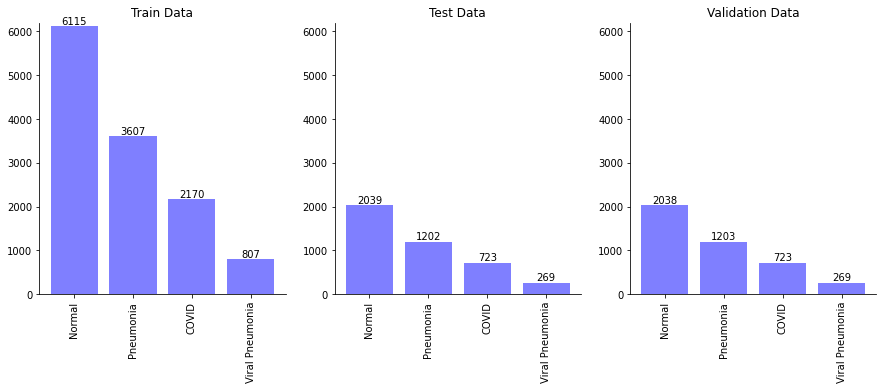

In [9]:
import matplotlib.pyplot as plt
def bar_plot(dff, main):
    fig1 = plt.bar(dff['target'].value_counts().index, 
                 dff['target'].value_counts().values, 
                 align='center', alpha=0.5, color='b',
                 )
    plt.ylim(0,6200)
    for rect in fig1:
      height = rect.get_height()
      plt.text(rect.get_x() + rect.get_width()/2., 
              height, f'{height:.0f}', ha='center', va='bottom')
    plt.xticks(rotation=90)
    plt.title(main)

def plot_data_split(train_df, test_df, val_df):
    plt.figure(figsize=(15, 5))
    plt.rcParams['axes.spines.right'] = False 
    plt.rcParams['axes.spines.top'] = False

    # plt.axis('off')
    plt.subplot(131)
    bar_plot(train_df, 'Train Data')

    plt.subplot(132)
    bar_plot(test_df, 'Test Data')
    plt.subplot(133)
    bar_plot(val_df, 'Validation Data')

plot_data_split(train_df, test_df, val_df)

# Create Data Generator

In [71]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMG_SHAPE = (224, 224, 3)

def generate_train_val_data(train_dff, val_dff, test_dff, IMG_SIZE=(224, 224), 
                            BATCH_SIZE=32, IMG_SHAPE=(224, 224, 3)):
  train_datagen = ImageDataGenerator(
      rotation_range=0.1, 
      shear_range=0.1,
  )

  val_datagen = ImageDataGenerator()

  train_gen = train_datagen.flow_from_dataframe(
      train_dff, x_col='path', y_col='target', 
      target_size=IMG_SIZE, shuffle=True, 
      batch_size=BATCH_SIZE, class_mode='categorical'
  )

  val_gen = val_datagen.flow_from_dataframe(
      val_dff, x_col='path', y_col='target', 
      target_size=IMG_SIZE, shuffle=False, 
      batch_size=BATCH_SIZE, class_mode='categorical', 
  )

  test_datagen = ImageDataGenerator()
  test_gen = test_datagen.flow_from_dataframe(
      test_dff, x_col='path', y_col='target', 
      target_size=IMG_SIZE, shuffle=False, 
      batch_size=BATCH_SIZE, class_mode='categorical'
  )

  return train_gen, val_gen, test_gen

train_generator, val_generator, test_generator = generate_train_val_data(train_df, val_df, test_df)

Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.


In [25]:
train_generator.class_indices

{'COVID': 0, 'Normal': 1, 'Pneumonia': 2, 'Viral Pneumonia': 3}

In [40]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_wts = {}
for ind, wt in enumerate(class_weights):
    class_wts[ind] = wt
class_wts

{0: 1.4630184331797236,
 1: 0.5191741618969746,
 2: 0.8801635708344885,
 3: 3.934014869888476}

In [41]:
TRAIN_SAMPLES = train_df.shape[0]
VAL_SAMPLES = val_df.shape[0]

METRICS = ['accuracy', 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.Precision(name='precision')]

# Define Required Functions

## Define Model

In [45]:
def get_model(base_model, IMG_SHAPE = (224, 224, 3), ):
    inputs = keras.Input(shape=IMG_SHAPE)
    x = keras.layers.Normalization()(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    outputs = keras.layers.Dense(4, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer = keras.optimizers.Adam(),
        loss = 'categorical_crossentropy',
        metrics=METRICS
    )
    return model

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.002, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

def get_callbacks(save_file_name):
    callbacks = [
             keras.callbacks.ModelCheckpoint(
                  save_file_name, save_best_only=True
             ),
             lr_scheduler,
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
    ]
    return callbacks

def fit_model(model, epoch, callback):
    return model.fit(
    train_generator, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = val_generator, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=epoch, 
    callbacks=callback,
    class_weight=class_wts
    )

## Create train data for classification report

In [47]:
# creating test_images and labels
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
test_images, test_labels = [], []
for row in test_df.iterrows():
  img = load_img(row[1]['path'], target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  test_images.append(x)
  test_labels.append(row[1]['target'])

## Classification report for test dataset

In [93]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# predict array
def predict_image(model):
  predict = []
  for img in test_images:
    pred = model.predict(img)
    predict.append(pred)

  return predict 

class_decode = dict()
for key, value in train_generator.class_indices.items():
  class_decode[value] = key


def decode_prediction(predict_array):
  predict_names = []
  for pred in predict_array:
    name = class_decode[np.argmax(pred)]
    predict_names.append(name)
  return predict_names


def confusion_matrix_plot(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  counts = [str(value) for value in cm.flatten()]
  percents = ["{0:.3%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(counts, percents)]
  labels = np.asarray(labels).reshape(4,4)
  cm_df = pd.DataFrame(cm)
  cm_df.index.name = 'Actual'
  cm_df.columns.name = 'Predicted'
  plt.figure(figsize=(10,10))
  sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', 
          annot_kws={'size':16}, 
          yticklabels=['COVID', 'Normal', 'Pneumonia', 'Viral Pneumonia'],
          xticklabels=['COVID', 'Normal', 'Pneumonia', 'Viral Pneumonia'],
          cbar=False)

def test_report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  confusion_matrix_plot(y_true, y_pred)


# Resnet50

In [46]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
base_model_resnet50 = tf.keras.applications.ResNet50(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model_resnet50.trainable = False 
model_resnet50 = get_model(base_model_resnet50)
start = datetime.now()
history_resent50 = fit_model(model_resnet50, 20, get_callbacks('resnet50.h5'))
end = datetime.now()
print('Running Time'.ljust(20, '.'), end - start)

Epoch 1/20
396/396 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.7448 - recall: 0.6936 - precision: 0.7813

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


396/396 [==============================] - 230s 567ms/step - loss: 0.5872 - accuracy: 0.7448 - recall: 0.6936 - precision: 0.7813 - val_loss: 0.4215 - val_accuracy: 0.8487 - val_recall: 0.8132 - val_precision: 0.8723 - lr: 0.0020
Epoch 2/20
396/396 [==============================] - 227s 572ms/step - loss: 0.3747 - accuracy: 0.8337 - recall: 0.8000 - precision: 0.8571 - val_loss: 0.4389 - val_accuracy: 0.8369 - val_recall: 0.8026 - val_precision: 0.8644 - lr: 0.0018
Epoch 3/20
396/396 [==============================] - 229s 577ms/step - loss: 0.3262 - accuracy: 0.8542 - recall: 0.8300 - precision: 0.8722 - val_loss: 0.3664 - val_accuracy: 0.8722 - val_recall: 0.8456 - val_precision: 0.8934 - lr: 0.0016
Epoch 4/20
396/396 [==============================] - 222s 562ms/step - loss: 0.2789 - accuracy: 0.8691 - recall: 0.8510 - precision: 0.8845 - val_loss: 0.3325 - val_accuracy: 0.8861 - val_recall: 0.8719 - val_precision: 0.8979 - lr: 0.0014
Epoch 5/20
396/396 [===========================

In [72]:
model_resnet50.evaluate(test_generator)

133/133 [==============================] - 31s 234ms/step - loss: 0.2215 - accuracy: 0.9272 - recall: 0.9253 - precision: 0.9297


[0.22153304517269135,
 0.9272383451461792,
 0.9253484606742859,
 0.9297412633895874]

In [100]:
import pandas as pd 
resnet50_df = pd.DataFrame(history_resent50.history)
resnet50_df

,loss,accuracy,recall,precision,val_loss,val_accuracy,val_recall,val_precision,lr
0,0.587224,0.744770,0.693613,0.781256,0.421490,0.848722,0.813210,0.872270,0.002000
1,0.374693,0.833741,0.800032,0.857143,0.438913,0.836884,0.802557,0.864355,0.001783
2,0.326163,0.854188,0.830031,0.872242,0.366434,0.872159,0.845644,0.893447,0.001589
3,0.278937,0.869109,0.850951,0.884540,0.332497,0.886127,0.871922,0.897855,0.001416
4,0.254065,0.882293,0.863425,0.895521,0.283791,0.893466,0.884943,0.902027,0.001262
5,0.235595,0.887661,0.874793,0.897683,0.294669,0.892756,0.878788,0.900752,0.001125
6,0.210245,0.900371,0.887740,0.911264,0.286628,0.901989,0.889915,0.908629,0.001002
7,0.198895,0.902345,0.893819,0.909617,0.267281,0.902936,0.896544,0.910555,0.000893
8,0.188105,0.911897,0.902739,0.919360,0.307619,0.888494,0.875237,0.898420,0.000796
9,0.171931,0.914186,0.907476,0.921665,0.324990,0.875237,0.867188,0.885638,0.000710


Text(0.5, 0.98, 'ResNet 50')

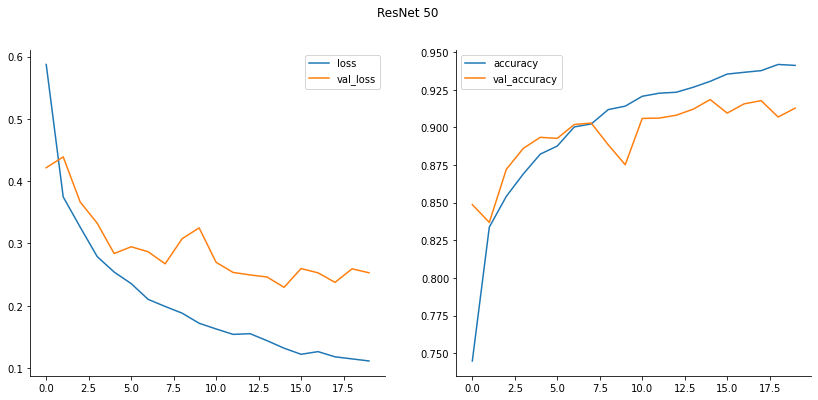

In [113]:

fig, ax = plt.subplots(1,2)

resnet50_df[['loss', 'val_loss']].plot(ax=ax[0], figsize=(14,6))
resnet50_df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
plt.suptitle('ResNet 50')

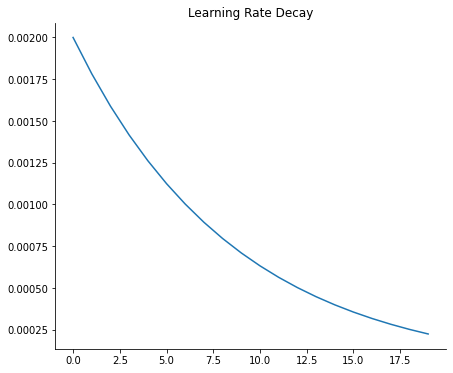

In [115]:
resnet50_df['lr'].plot(figsize=(7,6), title='Learning Rate Decay')

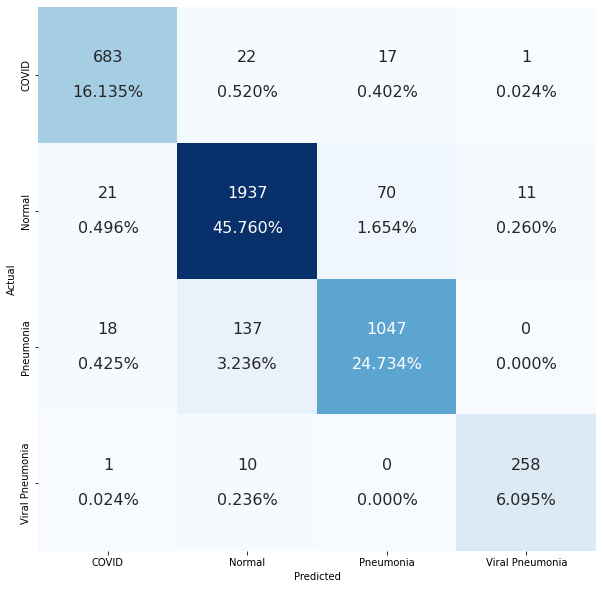

In [82]:
# confusion_matrix_plot(test_labels, predict_name)

In [77]:
# print(classification_report(test_labels, predict_name))

                 precision    recall  f1-score   support

          COVID       0.94      0.94      0.94       723
         Normal       0.92      0.95      0.93      2039
      Pneumonia       0.92      0.87      0.90      1202
Viral Pneumonia       0.96      0.96      0.96       269

       accuracy                           0.93      4233
      macro avg       0.94      0.93      0.93      4233
   weighted avg       0.93      0.93      0.93      4233



# VGG19

In [84]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input
base_model_vgg19 = tf.keras.applications.VGG19(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model_vgg19.trainable = False 

model_vgg19 = get_model(base_model_vgg19)
start = datetime.now()
history_vgg19 = fit_model(model_vgg19, 20, get_callbacks('vgg19.h5'))
end = datetime.now()
print('Running Time'.ljust(20, '.'), end - start)

80150528/80134624 [==============================] - 2s 0us/step
Epoch 1/20
396/396 [==============================] - 247s 594ms/step - loss: 0.6604 - accuracy: 0.7238 - recall: 0.6131 - precision: 0.6788 - val_loss: 0.4194 - val_accuracy: 0.8482 - val_recall: 0.8198 - val_precision: 0.8736 - lr: 0.0020
Epoch 2/20
396/396 [==============================] - 229s 578ms/step - loss: 0.4170 - accuracy: 0.8086 - recall: 0.7722 - precision: 0.8363 - val_loss: 0.4208 - val_accuracy: 0.8374 - val_recall: 0.8125 - val_precision: 0.8623 - lr: 0.0018
Epoch 3/20
396/396 [==============================] - 244s 615ms/step - loss: 0.3523 - accuracy: 0.8345 - recall: 0.8086 - precision: 0.8544 - val_loss: 0.3500 - val_accuracy: 0.8748 - val_recall: 0.8504 - val_precision: 0.8920 - lr: 0.0016
Epoch 4/20
396/396 [==============================] - 240s 606ms/step - loss: 0.3091 - accuracy: 0.8545 - recall: 0.8360 - precision: 0.8708 - val_loss: 0.3622 - val_accuracy: 0.8629 - val_recall: 0.8499 - val_pr

                 precision    recall  f1-score   support

          COVID       0.93      0.93      0.93       723
         Normal       0.93      0.90      0.91      2039
      Pneumonia       0.85      0.90      0.87      1202
Viral Pneumonia       0.95      0.96      0.95       269

       accuracy                           0.91      4233
      macro avg       0.92      0.92      0.92      4233
   weighted avg       0.91      0.91      0.91      4233



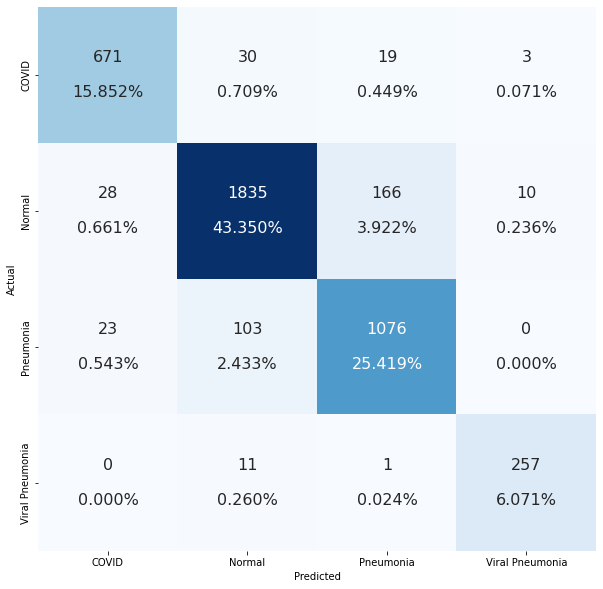

In [94]:
pred_arrs_vgg19 = predict_image(model_vgg19)
pred_names = decode_prediction(pred_arrs_vgg19)
test_report(test_labels, pred_names)

In [85]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
base_model_rn101 = tf.keras.applications.ResNet101(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model_rn101.trainable = False 


model_rn101 = get_model(base_model_rn101)
start = datetime.now()
history_rn101 = fit_model(model_rn101, 20, get_callbacks('rn101.h5'))
end = datetime.now()
print('Running Time'.ljust(20, '.'), end - start)

171458560/171446536 [==============================] - 5s 0us/step
Epoch 1/20
396/396 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.7368 - recall: 0.7397 - precision: 0.8100

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


396/396 [==============================] - 307s 725ms/step - loss: 0.5905 - accuracy: 0.7368 - recall: 0.7397 - precision: 0.8100 - val_loss: 0.4397 - val_accuracy: 0.8120 - val_recall: 0.7836 - val_precision: 0.8294 - lr: 0.0020
Epoch 2/20
396/396 [==============================] - 266s 672ms/step - loss: 0.3778 - accuracy: 0.8252 - recall: 0.7937 - precision: 0.8492 - val_loss: 0.3405 - val_accuracy: 0.8736 - val_recall: 0.8492 - val_precision: 0.8927 - lr: 0.0018
Epoch 3/20
396/396 [==============================] - 268s 677ms/step - loss: 0.3192 - accuracy: 0.8563 - recall: 0.8352 - precision: 0.8739 - val_loss: 0.3819 - val_accuracy: 0.8641 - val_recall: 0.8348 - val_precision: 0.8830 - lr: 0.0016
Epoch 4/20
396/396 [==============================] - 271s 684ms/step - loss: 0.2831 - accuracy: 0.8643 - recall: 0.8474 - precision: 0.8783 - val_loss: 0.2921 - val_accuracy: 0.8977 - val_recall: 0.8880 - val_precision: 0.9074 - lr: 0.0014
Epoch 5/20
396/396 [===========================

                 precision    recall  f1-score   support

          COVID       0.92      0.95      0.93       723
         Normal       0.92      0.93      0.93      2039
      Pneumonia       0.91      0.88      0.89      1202
Viral Pneumonia       0.95      0.97      0.96       269

       accuracy                           0.92      4233
      macro avg       0.93      0.93      0.93      4233
   weighted avg       0.92      0.92      0.92      4233



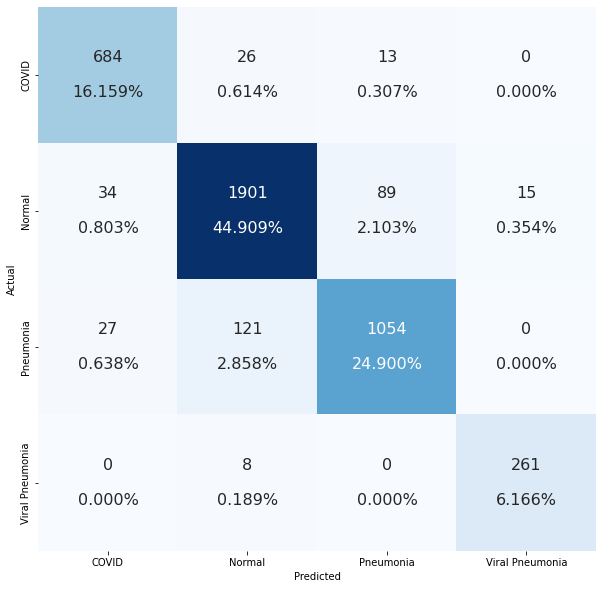

In [95]:
pred_arrs_rn101 = predict_image(model_rn101)
pred_names = decode_prediction(pred_arrs_rn101)
test_report(test_labels, pred_names)